##### Load dependencies

In [1]:
from cil.framework import AcquisitionData, DataContainer
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.io.utilities import HDF5_utilities
from cil.io import TIFFWriter
from cil.processors import RingRemover, Padder, Slicer, TransmissionAbsorptionConverter, CentreOfRotationCorrector, PaganinProcessor
from cil.recon import FBP

import hdf5plugin
import numpy as np
import matplotlib.pyplot as plt
import glob
import os


In [2]:
from scripts.HDF5_ParallelDataReader import HDF5_ParallelDataReader
from scripts.Normaliser import Normaliser
from scripts.WeightDuplicateAngles import WeightDuplicateAngles

##### Load the data

Specify the parent directory and list the scans

In [3]:
# specify the parent directory
parent_directory = '/mnt/data/ESRF/test_data/'

# list the scans in the directory
files = glob.glob(os.path.join(parent_directory, '*.h5'))
for i, file in enumerate(files):
    print(str(i) + ': ' + str(file))


0: /mnt/data/ESRF/test_data/PC811_1000cycles_absct_final_0001.h5


Use CIL `HDF5_utilities` functions to read the file metadata

In [4]:
# choose the number of the file in the files list 
filename = files[0]

# or uncomment below to specify the filename directly
# filename = '/mnt/data/ESRF/Wedgescan_Iterative_ASSB/InSitu-LPSCL-20Ton-30Min_0001.h5'
HDF5_utilities.print_metadata(filename)

	 - 1.1 : <HDF5 group "/1.1" (6 members)>
		 - end_time : <HDF5 dataset "end_time": shape (), type "|O">
		 - instrument : <HDF5 group "/1.1/instrument" (37 members)>
			 - epoch_trig : <HDF5 group "/1.1/instrument/epoch_trig" (1 members)>
				 - data : <HDF5 dataset "data": shape (1600,), type "<f8">
						 - units : s
			 - fpico2 : <HDF5 group "/1.1/instrument/fpico2" (1 members)>
				 - data : <HDF5 dataset "data": shape (1600,), type "<f8">
			 - fpico3 : <HDF5 group "/1.1/instrument/fpico3" (1 members)>
				 - data : <HDF5 dataset "data": shape (1600,), type "<f8">
			 - fscan_parameters : <HDF5 group "/1.1/instrument/fscan_parameters" (24 members)>
				 - acq_time : <HDF5 dataset "acq_time": shape (), type "<f8">
				 - camera_signal : <HDF5 dataset "camera_signal": shape (), type "|O">
				 - display_flag : <HDF5 dataset "display_flag": shape (), type "|b1">
				 - fast_acc_margin : <HDF5 dataset "fast_acc_margin": shape (), type "<f8">
				 - fast_motor : <HDF5 dataset "fast_m

Read the data
- Create a `HDF5_ParallelDataReader` object 
- Configure the paths to relevant data and metadata in the file
- Read the data

In [5]:
reader = HDF5_ParallelDataReader(filename, 
                                 dataset_path=('1.1/measurement/pcoedgehs/',
                                               '4.1/measurement/pcoedgehs/'),
                                 distance_units='mm', angle_units='degree')

reader.configure_angles(angles_path=('1.1/measurement/hrrz_center',
                        '4.1/measurement/hrrz_center'))

reader.configure_pixel_sizes('1.1/instrument/pcoedgehs/x_pixel_size',
                             '1.1/instrument/pcoedgehs/y_pixel_size', HDF5_units = 'um')

reader.configure_normalisation_data(flatfield_path='2.1/measurement/pcoedgehs/',
                                    darkfield_path='3.1/measurement/pcoedgehs/')

reader.configure_sample_detector_distance(sample_detector_distance=90, HDF5_units='mm')

data = reader.read()

##### Normalise

First normalise by flux
- Specify the location of the beam monitor in the data file
- Normalise using the CIL `Normaliser.flux()` method
- Compare the result to un-normalised data

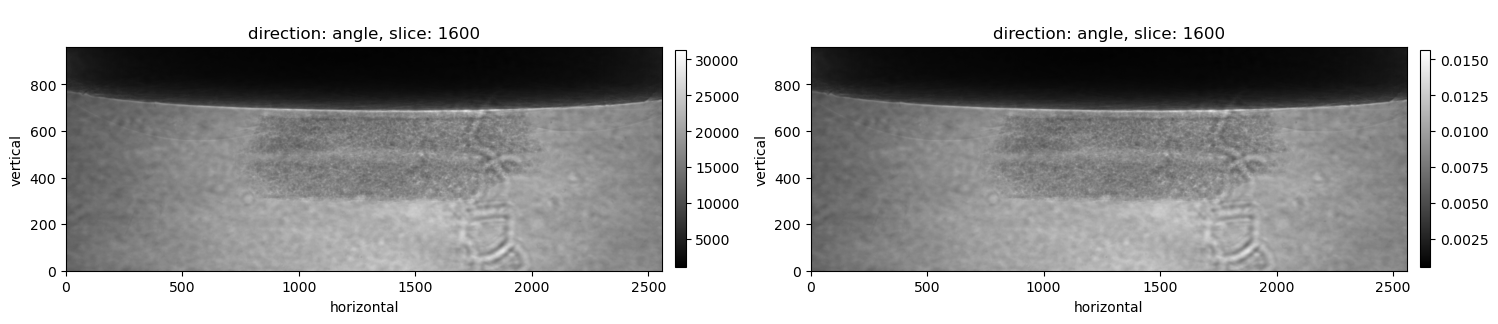

In [6]:
data_before = data.copy()

beam_current = np.concatenate((HDF5_utilities.read(filename, '1.1/instrument/fpico2/data/'),
                HDF5_utilities.read(filename, '4.1/instrument/fpico2/data/')))

processor = Normaliser.flux(flux=beam_current)
processor.set_input(data)
processor.get_output(out=data)

show2D([data_before, data])

Also normalise the flat and dark scans using the same method
- First calculate the number of times the flat field is repeated
- Create an `AcquisitionData` object with the flatfield data in
- Use `HDF5_utilities` to load the beam current from the data file
- Normalise the flat field data using `Normaliser.flux()`

In [7]:
try:
    num_repeats = len(reader.flatfield)
except:
    num_repeats = 1
geom = data.geometry.copy()
geom.set_angles(np.ones(num_repeats))

flatfield = AcquisitionData(reader.flatfield, geometry=geom)
beam_current = HDF5_utilities.read(filename, '2.1/instrument/fpico2/data/')
processor = Normaliser.flux(flux=beam_current)
processor.set_input(flatfield)
processor.get_output(flatfield)

Repeat for darkfield data

In [8]:
try:
    num_repeats = len(reader.darkfield)
except:
    num_repeats = 1
geom = data.geometry.copy()
geom.set_angles(np.ones(num_repeats))
darkfield = AcquisitionData(reader.darkfield, geometry=geom)
beam_current = HDF5_utilities.read(filename, '3.1/instrument/fpico2/data/')
processor = Normaliser.flux(flux=beam_current)
processor.set_input(darkfield)
processor.get_output(darkfield)

Next normalise the data using the flat and dark scans
- Use the CIL `Normaliser.flat_and_dark` method
- Specify the flat and dark scans, averaged along the axis of repeat scans
- Compare the results to un-normalised data

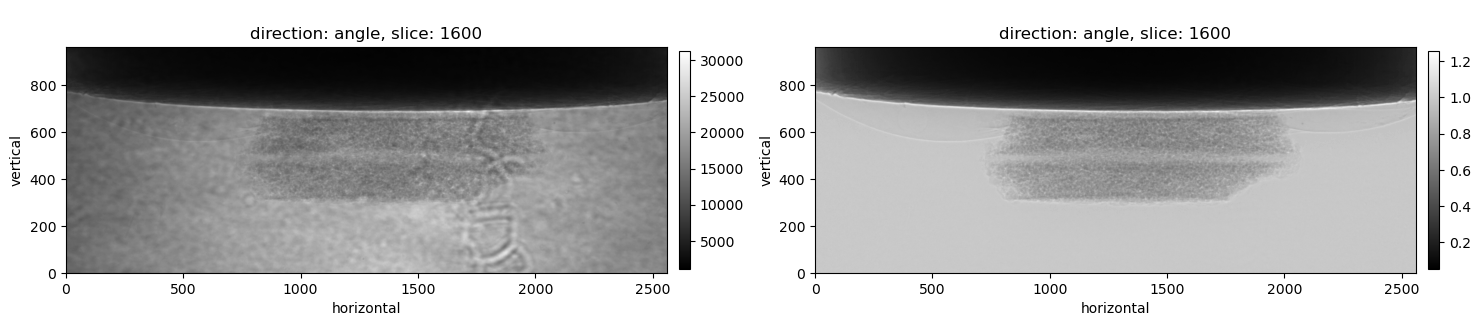

In [9]:
processor = Normaliser.flat_and_dark(flat_field=np.mean(flatfield.array, axis = 0),
                                      dark_field=np.mean(darkfield.array, axis = 0))
processor.set_input(data)
data = processor.get_output()

show2D([data_before, data])

##### Phase retrieval

Get the experiment energy from the data file

In [10]:
energy = HDF5_utilities.read(filename, '/1.1/instrument/positioners/llen')
print(energy)

40.00003


Run the CIL `PaganinProcessor`
- Input the energy and units
- Increase ratio of `delta/beta` to increase the strength of the filter
- `full_retrieval = False` means the calcultion does not include $-log()$  

100%|██████████| 3200/3200 [05:57<00:00,  8.95it/s]


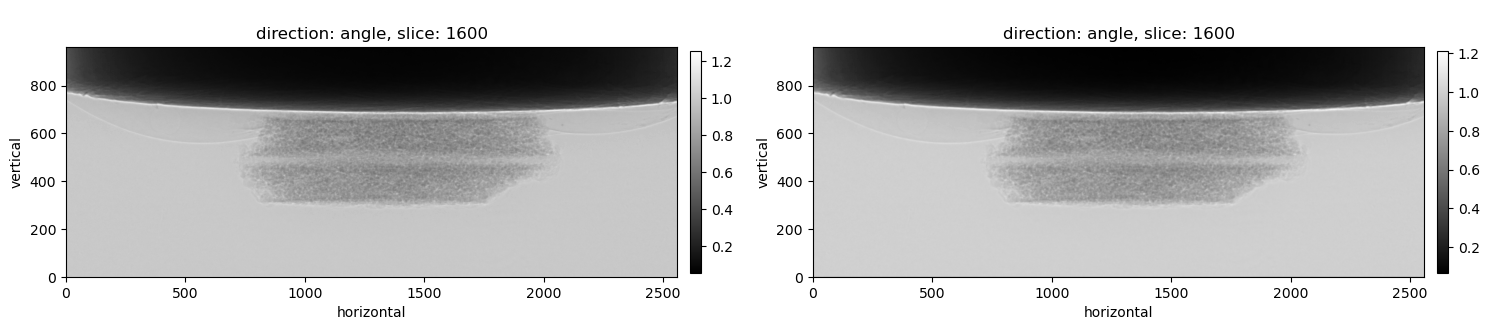

In [11]:
data_before = data.copy()

processor = PaganinProcessor(delta=1, beta=0.01, 
                             energy=energy, energy_units='keV', 
                             full_retrieval=False)
processor.set_input(data)
data = processor.get_output()
show2D([data_before, data])

Zoom in on the result

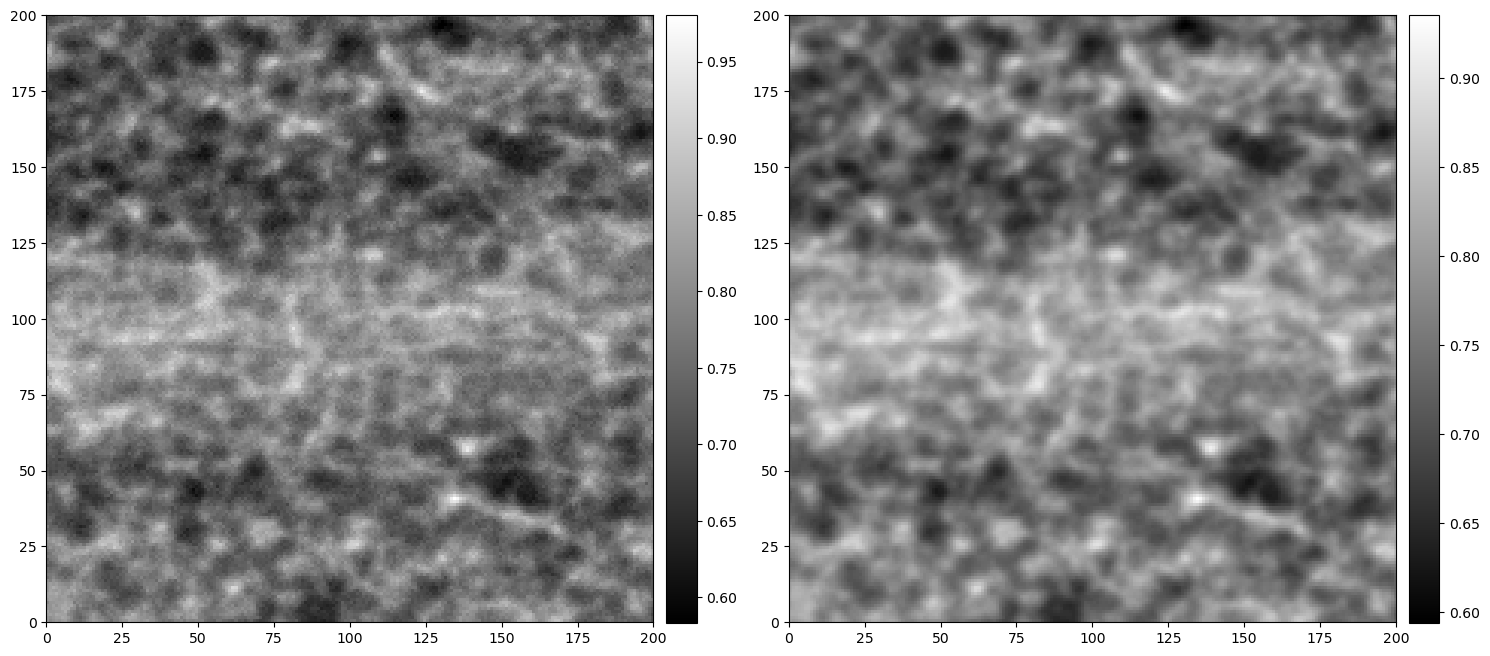

In [12]:
show2D([data_before.array[1600,400:600,1000:1200], data.array[1600,400:600,1000:1200]])

Check the effect of the phase retrieval on a reconstruction from a single slice

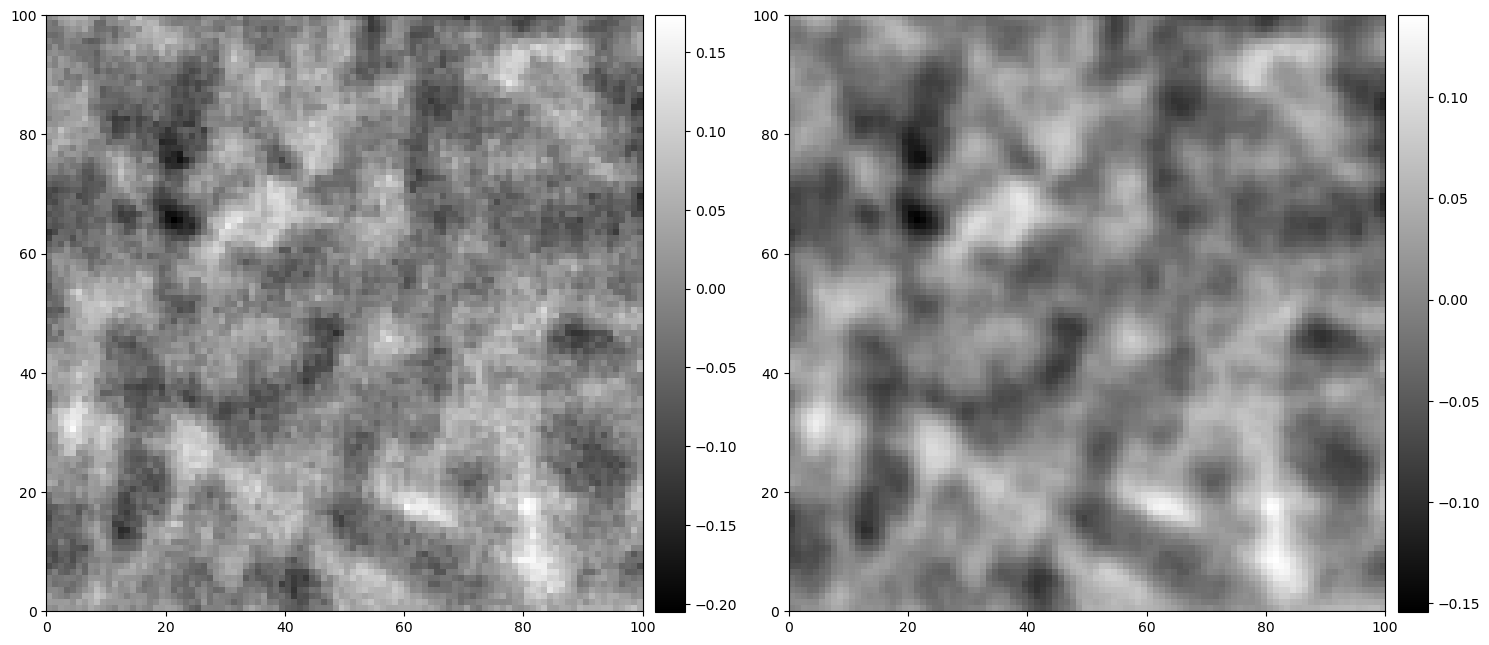

In [13]:
vertical_slice = 450

data_slice = data_before.get_slice(vertical=vertical_slice)
reco_before = FBP(data_slice).run(verbose=False)
reco_before.apply_circular_mask(0.9)


data_slice = data.get_slice(vertical=vertical_slice)
reco = FBP(data_slice).run(verbose=False)
reco.apply_circular_mask(0.9)

show2D([reco_before.array[1000:1100,1000:1100], reco.array[1000:1100,1000:1100]])

Plot a cross-section through the reconstruction

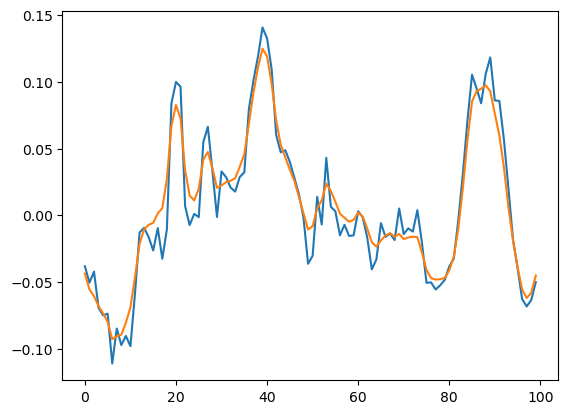

In [14]:
plt.plot(reco_before.array[1100,1100:1200])
plt.plot(reco.array[1100,1100:1200])

##### Transmission to absorption 

Use the CIL `TransmissionAbsorptionConverter`
- If there are negative numbers in the data, specify a low value in `min_intensity` to clip these values before calculating -log

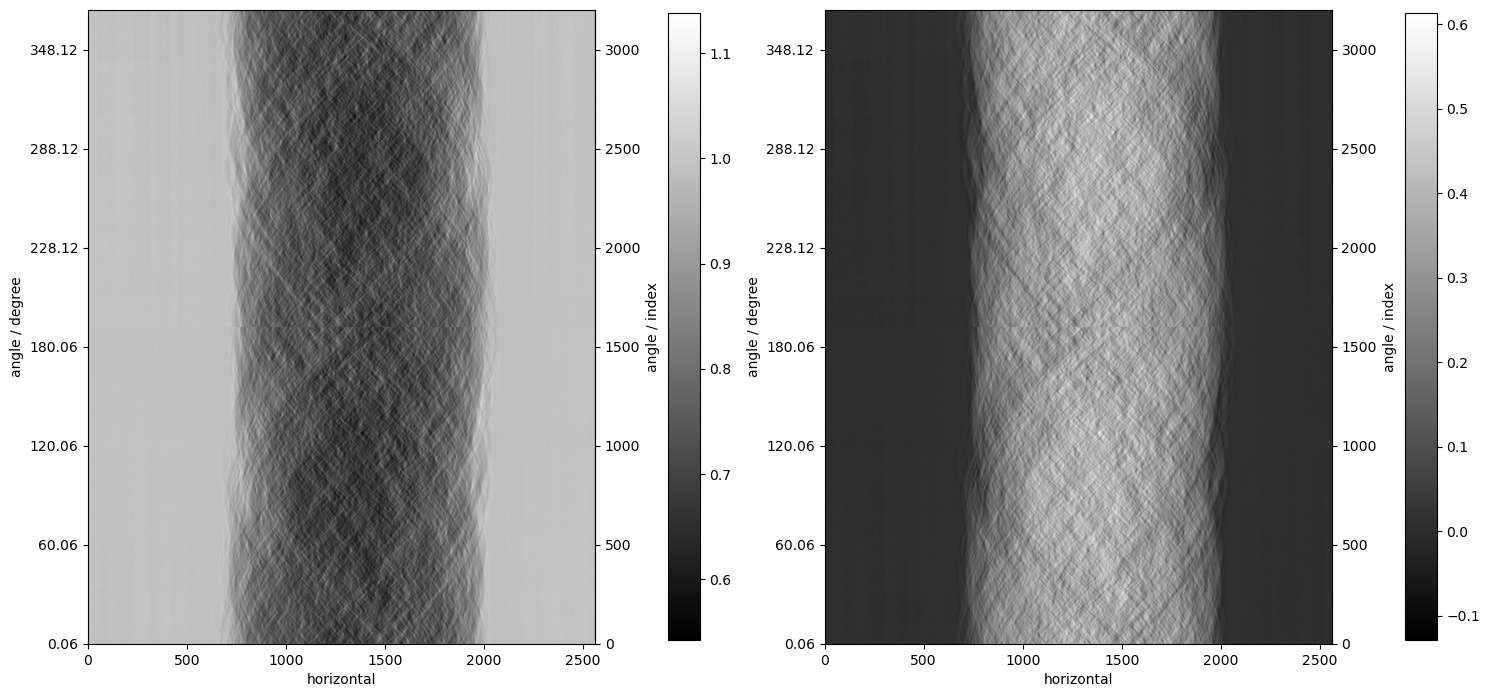

In [15]:
data_before = data_slice.copy()

processor = TransmissionAbsorptionConverter(min_intensity=0.001)
processor.set_input(data_slice)
processor.get_output(out=data_slice)

show2D([data_before, data_slice])

reco_before = FBP(data_slice).run(verbose=False)

##### Centre of rotation correction

If the data has projections which are 180 degrees apart, uncomment this cell to use the CIL `CentreOfRotationCorrector.xcorrelation` processor to find the centre of rotation offset automatically
- Specify a first projection to use for the correlation, and the algorithm will identify the second angle which is 180 degrees from the first - within a specified angular tolerance 

In [16]:
processor = CentreOfRotationCorrector.xcorrelation()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

print(data_slice.geometry)

2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0.54483, 0.     ]
	Detector position: [ 0., 90.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [2560    1]
	Pixel size: [0.0065 0.0065]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3200
	Angles 0-9 in degrees: [0.05950433, 0.17946315, 0.29948136, 0.41944018, 0.53951776, 0.65947664,
 0.7795542 , 0.89951307, 1.0194719 , 1.1395495 ]
	Angles 3190-3199 in degrees: [370.9201 , 371.0402 , 371.16016, 371.28012, 371.40012, 371.52014,
 371.6401 , 371.7602 , 371.88013, 372.0001 ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


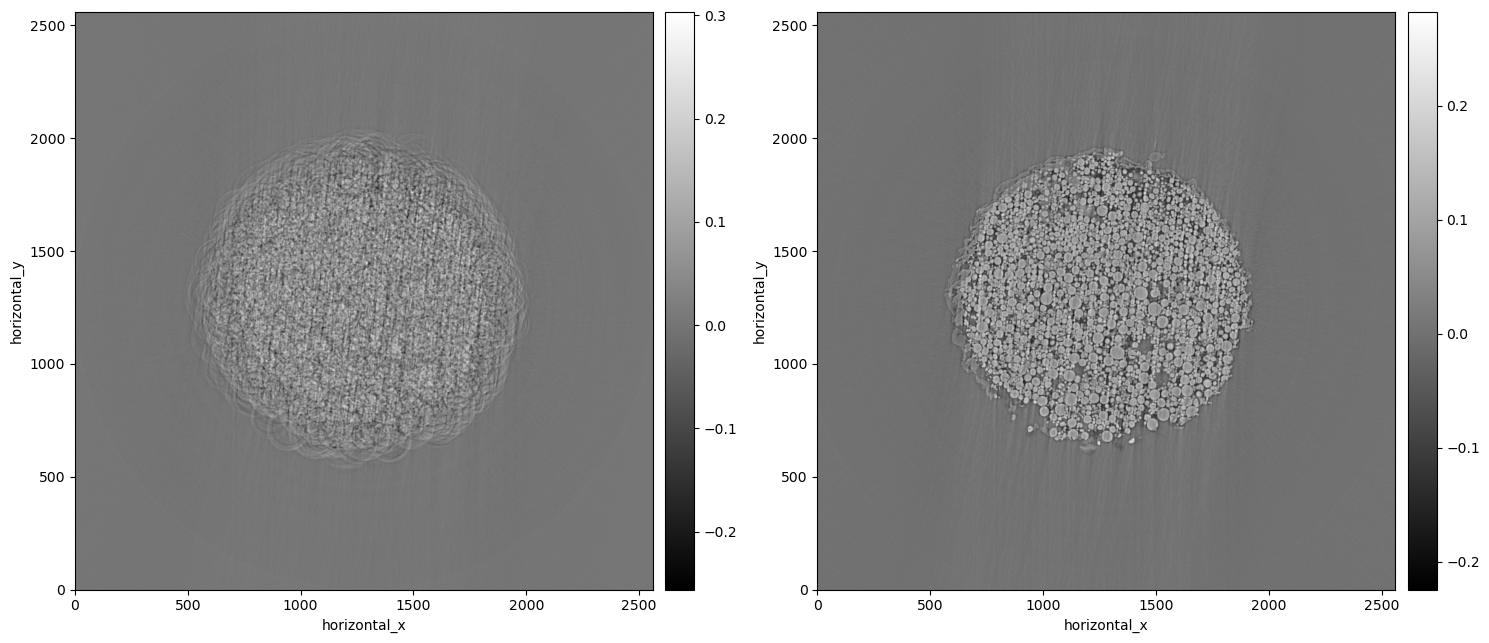

In [17]:
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before, reco])

Alternatively manually enter a pixel offset. This could be extracted from the dataset metadata as a starting point

In [ ]:
# offset_rotation = HDF5_utilities.read(filename, '/1.1/instrument/positioners/idx')
# print(offset_rotation)

# # offset_rotation = HDF5_utilities.read(filename, '/1.1/instrument/positioners/hry')
# # print(offset_rotation)

# x_pixel_size = HDF5_utilities.read(filename, '/1.1/instrument/pcoedgehs/x_pixel_size')
# print(x_pixel_size)

# pixel_offset = ((offset_rotation/(x_pixel_size/1000))-(3200/2))
# print(pixel_offset)

25.0
6.5
2246.153846153846


Adjust the offset until the rotation artefacts are minimised

In [35]:
# pixel_offset = 83.78
array_list = []
pixel_offsets = [83.0, 83.2, 83.4, 83.6, 83.8]
for p in pixel_offsets:
    data_tmp = data_slice.copy()
    data_tmp.geometry.set_centre_of_rotation(p, distance_units='pixels')
    reco = FBP(data_tmp).run(verbose=False)
    array_list.append(reco.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Centre of rotation offset']) + reco.geometry.dimension_labels)
islicer(DC)


##### Crop the data

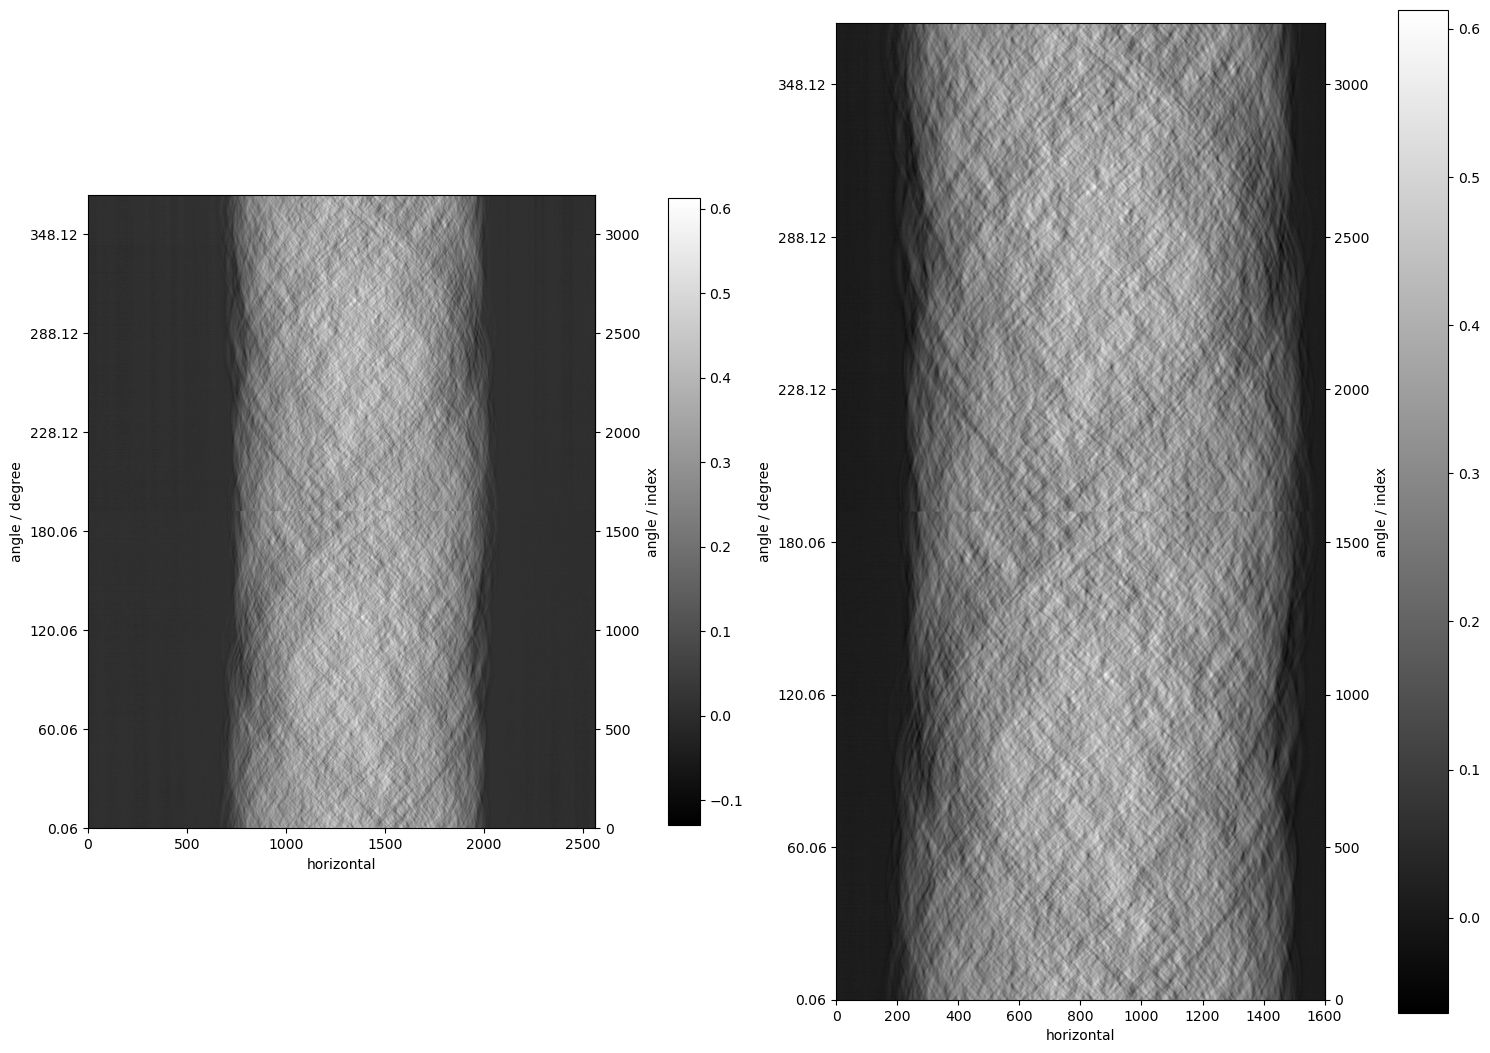

In [ ]:
data_before = data_slice.copy()

processor = Slicer(roi = {'horizontal':(500,2100,1)})
processor.set_input(data_slice)
data_slice = processor.get_output()

show2D([data_before, data_slice])


##### Weight duplicate angles

We have some angles with double the data so we see artifacts with FBP reconstruction. We can find the duplicate angles and weight them appropriately for FBP. Using `weight_duplicate_angles` from `weight_duplicate_angles.py`

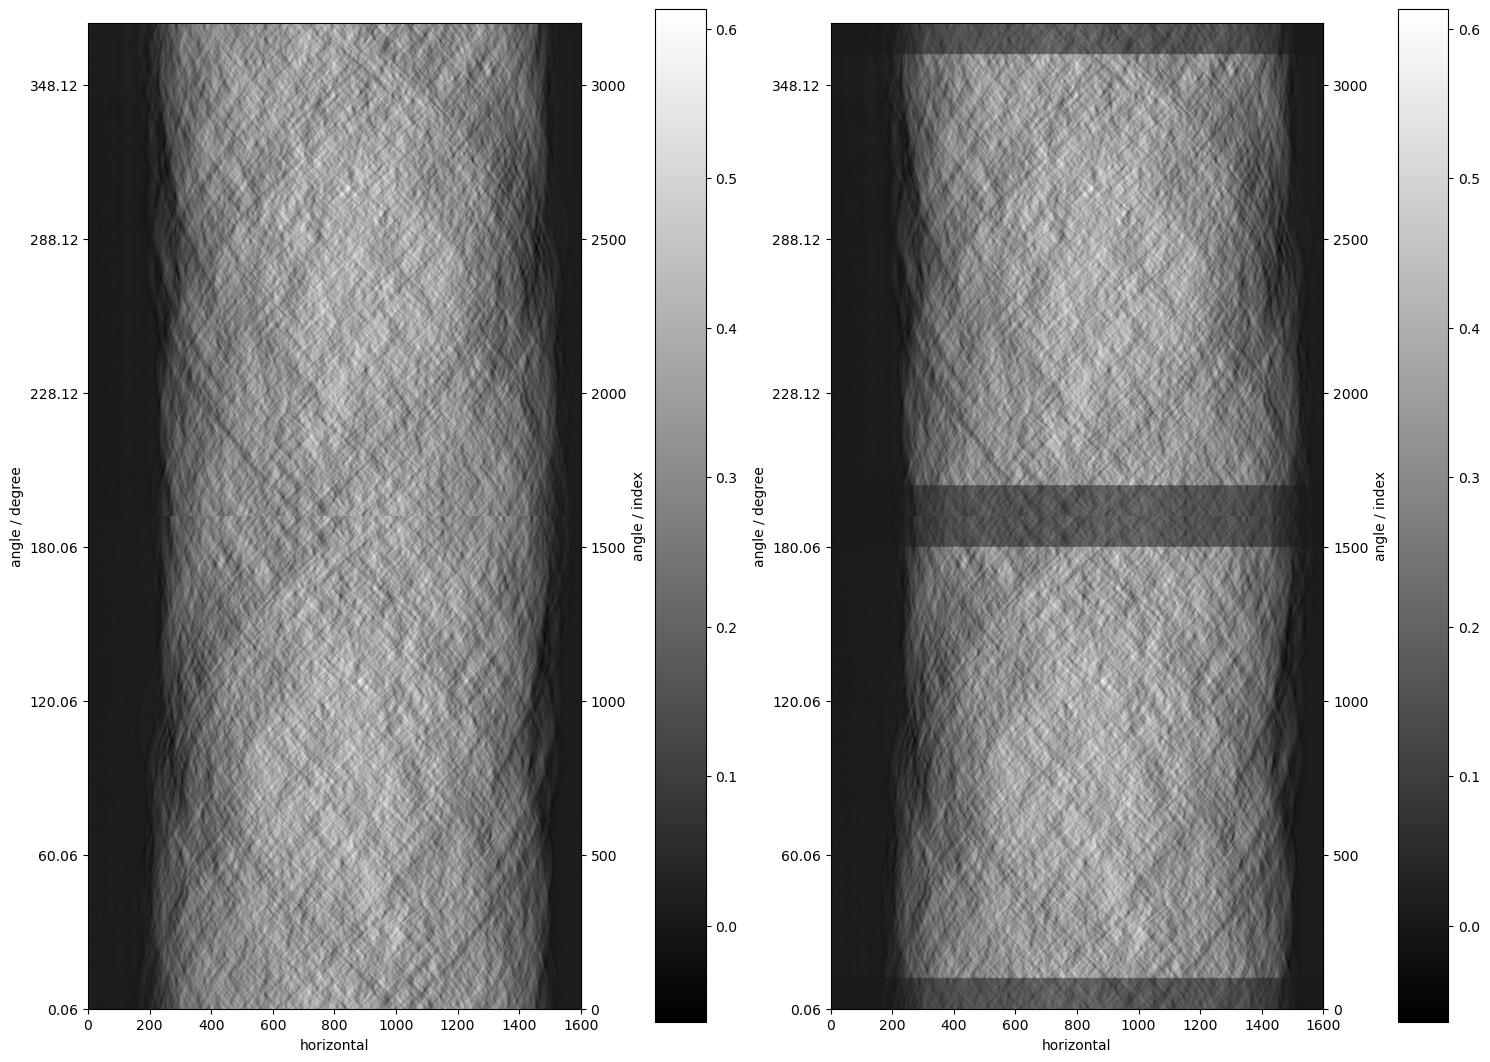

In [105]:
data_before = data_slice.copy()

processor = WeightDuplicateAngles()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

show2D([data_before, data_slice])

And now we reconstruct the corrected data

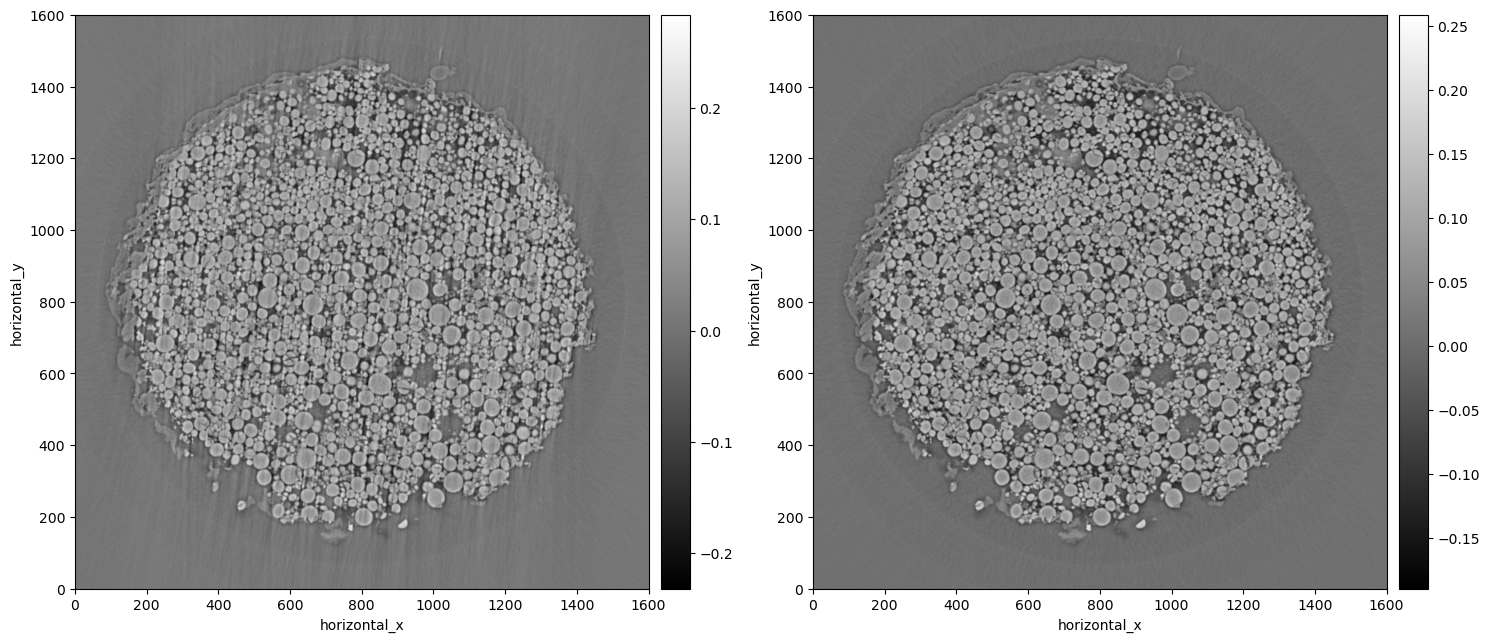

In [106]:
reco_before = FBP(data_before).run(verbose=False)
reco = FBP(data_slice).run(verbose=False)

show2D([reco_before, reco])

##### Ring remover

Use the CIL ring remover processor to remove rings using a wavelet decomposition method

- Increasing the number of decompositions increases the frequency of ring artefacts that can be removed
- Increasing sigma will increase the strength of the ring remover, but too high sigma will distort the profile of the image

In [107]:
data_before = data_slice.copy()

processor = RingRemover(decNum = 4, wname = "db25", sigma = 1.5,  info = True)
processor.set_input(data_slice)
processor.get_output(out=data_slice)

Finish Ring Remover


Check the reconstruction

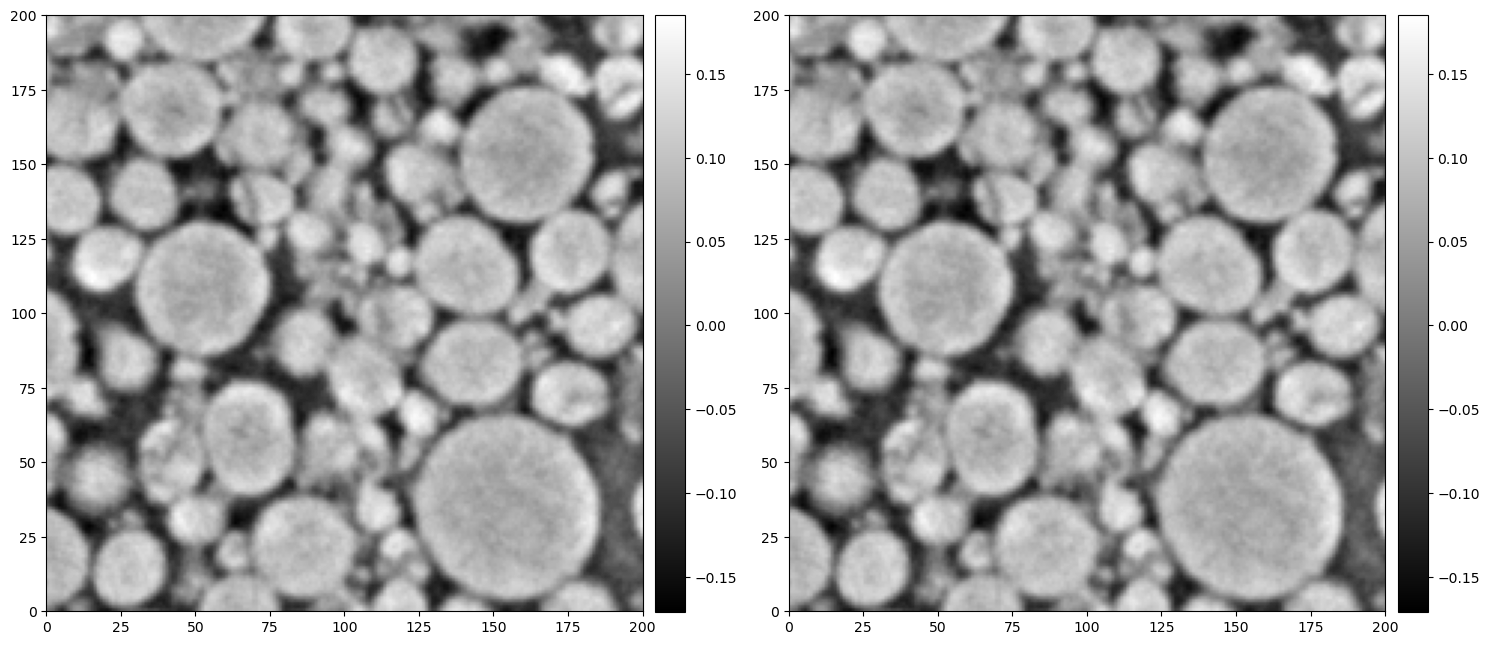

In [108]:
reco_before = FBP(data_before).run(verbose=False)
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before.array[800:1000,800:1000], reco.array[800:1000,800:1000]])

##### Unsharp mask

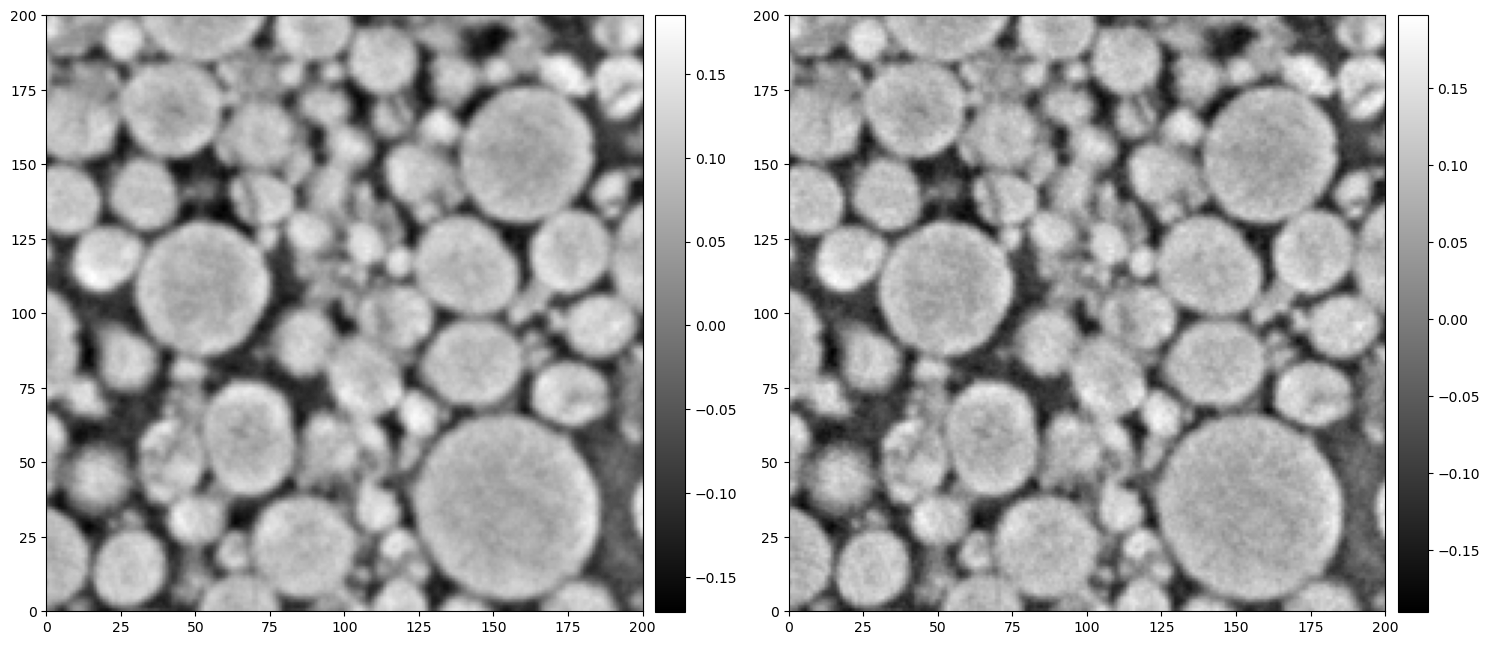

In [109]:
from nabu.processing.unsharp import UnsharpMask

data_test = data_slice.copy()

mask = UnsharpMask(shape=data_test.shape, sigma=0.1, coeff=1)
test = mask.unsharp(data_test.array)
data_test.fill(test)

reco_test = FBP(data_test).run(verbose=False)
show2D([reco.array[800:1000,800:1000], reco_test.array[800:1000,800:1000]])

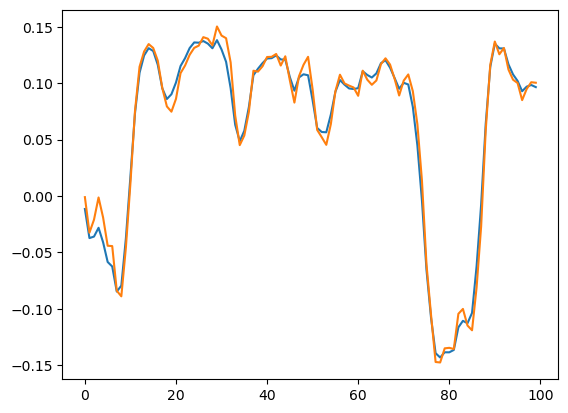

In [110]:
plt.plot(reco.array[1100,1100:1200])
plt.plot(reco_test.array[1100,1100:1200])

##### Save the processed data

Save the processed data as TIFF

In [ ]:
writer = TIFFWriter()
writer.set_up(data = data_test, file_name='path_to_data/data.tiff') #add data type, cast to float16
writer.write()